## Dataset Used  
[LFW (Labelled Faces in the Wild)](https://www.kaggle.com/datasets/jessicali9530/lfw-dataset)

## Dependencies

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50, EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Lambda, BatchNormalization,
    Dropout, GlobalAveragePooling2D, Layer, Activation, Conv2D, DepthwiseConv2D
)
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau,
    ModelCheckpoint, LearningRateScheduler
)
from tensorflow.keras.activations import relu as ReLU
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import random
import os

2025-09-23 21:27:23.339572: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758662843.558615      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758662843.621882      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Dataset Preparation

In [2]:
from pathlib import Path
dataset_path = Path("/kaggle/input/lfw-dataset")

matchpairs_train_csv = dataset_path / "matchpairsDevTrain.csv"
assert matchpairs_train_csv.exists(), f"Expected {matchpairs_train_csv} to exist."


mismatches_train_csv = dataset_path / "mismatchpairsDevTrain.csv"
assert mismatches_train_csv.exists(), f"Expected {mismatches_train_csv} to exist."

matchpairs_test_csv = dataset_path / "matchpairsDevTest.csv"
assert matchpairs_test_csv.exists(), f"Expected {matchpairs_test_csv} to exist."

mismatches_test_csv = dataset_path / "mismatchpairsDevTest.csv"
assert mismatches_test_csv.exists(), f"Expected {mismatches_test_csv} to exist."

In [3]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 128
EMBEDDING_SIZE = 128

MATCH_HEADERS = ["name", "imagenum1", "imagenum2"]
MISMATCH_HEADERS = ["name1", "imagenum1", "name2", "imagenum2"]


def get_image_path(person_name, image_num):
    img_name = f"{person_name}_{image_num:04d}.jpg"
    return (
        dataset_path / "lfw-deepfunneled" / "lfw-deepfunneled" / person_name / img_name
    )

def load_pairs_data(csv_file, is_match=True):
    df = pd.read_csv(
        csv_file, header=0, names=MATCH_HEADERS if is_match else MISMATCH_HEADERS
    )
    pairs = []
    labels = []

    for index, row in df.iterrows():
        if is_match:
            name = row["name"]
            img1_path = get_image_path(name, row["imagenum1"])
            img2_path = get_image_path(name, row["imagenum2"])
            label = 1  # Same person
        else:
            name1 = row["name1"]
            name2 = row["name2"]
            img1_path = get_image_path(name1, row["imagenum1"])
            img2_path = get_image_path(name2, row["imagenum2"])
            label = 0

        pairs.append((img1_path, img2_path))
        labels.append(label)

    return pairs, labels

In [4]:
match_pairs_train, match_labels_train = load_pairs_data(matchpairs_train_csv, is_match=True)
mismatch_pairs_train, mismatch_labels_train = load_pairs_data(mismatches_train_csv, is_match=False)

match_pairs_test, match_labels_test = load_pairs_data(matchpairs_test_csv, is_match=True)
mismatch_pairs_test, mismatch_labels_test = load_pairs_data(mismatches_test_csv, is_match=False)

matched_pairs = match_pairs_train + match_pairs_test
matched_labels = match_labels_train + match_labels_test

mismatched_pairs = mismatch_pairs_train + mismatch_pairs_test
mismatched_labels = mismatch_labels_train + mismatch_labels_test

all_pairs = matched_pairs + mismatched_pairs
all_labels = matched_labels + mismatched_labels
print(f"Total pairs: {len(all_pairs)}, Matches: {sum(all_labels)}, Mismatches: {len(all_labels) - sum(all_labels)}")

Total pairs: 3200, Matches: 1600, Mismatches: 1600


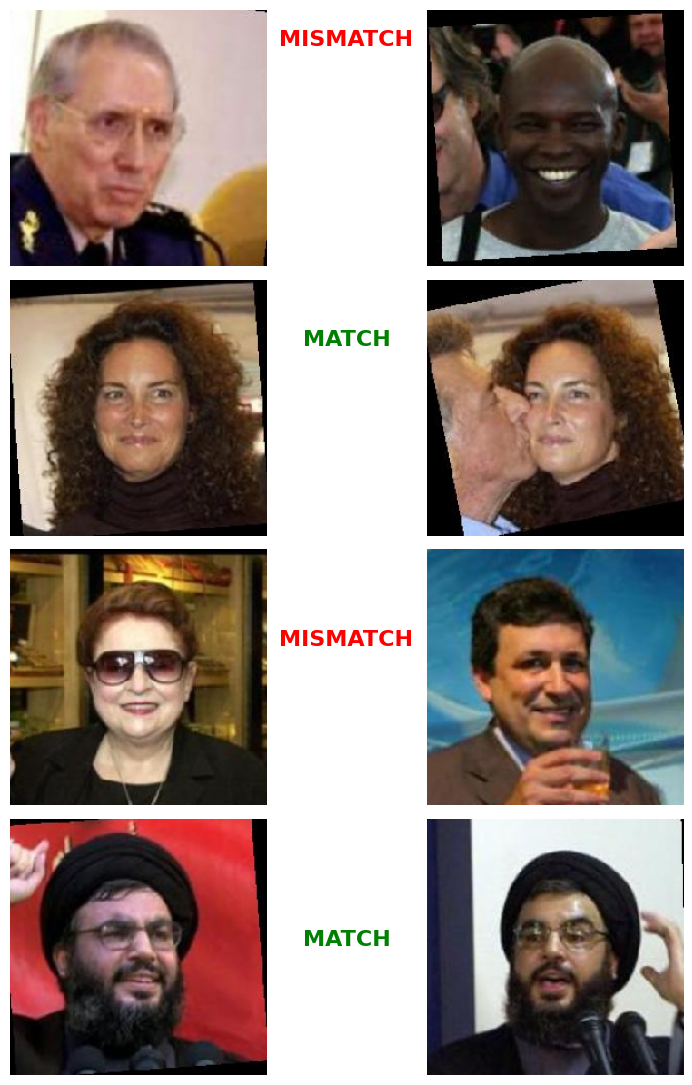

In [5]:
import numpy as np


def visualize_pairs(pairs, labels):
    n_pairs = len(pairs)
    fig, axes = plt.subplots(nrows=n_pairs, ncols=2, figsize=(10, 3 * n_pairs))

    if n_pairs == 1:
        axes = axes.reshape(1, 2)

    for i, (pair, label) in enumerate(zip(pairs, labels)):
        img1 = img_to_array(load_img(pair[0], target_size=IMG_SIZE)) / 255.0
        img2 = img_to_array(load_img(pair[1], target_size=IMG_SIZE)) / 255.0

        label_text = "MATCH" if label == 1 else "MISMATCH"
        color = "green" if label == 1 else "red"

        axes[i, 0].imshow(img1)
        axes[i, 0].axis("off")

        axes[i, 1].imshow(img2)
        axes[i, 1].axis("off")

        for ax in [axes[i, 0], axes[i, 1]]:
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_edgecolor(color)
                spine.set_linewidth(3)

        fig.text(
            0.5,
            1 - (i + 0.5) / n_pairs,
            f"{label_text}",
            ha="center",
            va="center",
            fontsize=16,
            fontweight="bold",
            color=color,
            transform=fig.transFigure,
        )

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


random_indices = random.sample(range(len(all_pairs)), 4)
pairs = [all_pairs[i] for i in random_indices]
labels = [all_labels[i] for i in random_indices]
visualize_pairs(pairs, labels)

In [6]:
def augment_image(img):
    if tf.reduce_max(img) > 1.0:
        img = tf.cast(img, tf.float32) / 255.0
    
    img = tf.image.random_flip_left_right(img)
    
    img = tf.image.random_brightness(img, max_delta=0.1)
    
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
    
    img = tf.image.random_saturation(img, lower=0.8, upper=1.2)
    
    img = tf.image.random_hue(img, max_delta=0.05)
    
    crop_size = tf.random.uniform([], 0.85, 1.0)
    img_shape = tf.shape(img)
    h, w = img_shape[0], img_shape[1]
    
    crop_h = tf.cast(tf.cast(h, tf.float32) * crop_size, tf.int32)
    crop_w = tf.cast(tf.cast(w, tf.float32) * crop_size, tf.int32)
    
    img = tf.image.random_crop(img, [crop_h, crop_w, 3])
    
    img = tf.image.resize(img, [h, w])
    
    angle = tf.random.uniform([], -0.175, 0.175)

    img = tf.clip_by_value(img, 0.0, 1.0)
    
    return img


def augment_image_pair(img1, img2, same_person=True, augment_both=True):

    if augment_both:
        # Independent augmentation for each imag
        img1_aug = augment_image(img1)
        img2_aug = augment_image(img2)
    else:
        if same_person:
            flip_random = tf.random.uniform([]) > 0.5
            if flip_random:
                img1 = tf.image.flip_left_right(img1)
                img2 = tf.image.flip_left_right(img2)
            
            img1_aug = augment_image(img1)
            img2_aug = augment_image(img2)
        else:
            img1_aug = augment_image(img1)
            img2_aug = augment_image(img2)
    
    return img1_aug, img2_aug

In [7]:
def decode_and_preprocess(path):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return img


def decode_and_preprocess_with_augment(path, apply_augment=False):
    img_bytes = tf.io.read_file(path)
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    
    if apply_augment:
        img = augment_image(img)
    
    img = img * 255.0
    img = preprocess_input(img)
    return img


def create_tf_dataset_optimized(pairs, labels, batch_size=32, shuffle=True, augment=False):
    img1_paths = tf.constant([str(p[0]) for p in pairs], dtype=tf.string)
    img2_paths = tf.constant([str(p[1]) for p in pairs], dtype=tf.string)
    y = tf.cast(tf.constant(labels), tf.float32)

    ds = tf.data.Dataset.from_tensor_slices(((img1_paths, img2_paths), y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(pairs), reshuffle_each_iteration=True)

    def map_fn(paths, label):
        p1, p2 = paths
        if augment:
            raw1 = decode_and_preprocess_with_augment(p1, apply_augment=True)
            raw2 = decode_and_preprocess_with_augment(p2, apply_augment=True)
        else:
            raw1 = decode_and_preprocess(p1)
            raw2 = decode_and_preprocess(p2)
        return (raw1, raw2), tf.reshape(label, [1])

    ds = ds.map(map_fn, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=False)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [8]:
def visualize_single_batch(dataset, num_pairs_to_show=3):
    for batch_pairs, batch_labels in dataset.take(1):
        img1_batch, img2_batch = batch_pairs

        n = min(num_pairs_to_show, len(batch_labels))

        fig, axes = plt.subplots(n, 2, figsize=(10, n * 3))
        if n == 1:
            axes = axes.reshape(1, 2)

        for i in range(n):
            img1 = img1_batch[i].numpy()
            img2 = img2_batch[i].numpy()
            label = int(batch_labels[i].numpy())

            label_text = "MATCH" if label == 1 else "MISMATCH"
            color = "green" if label == 1 else "red"

            axes[i, 0].imshow(np.clip(img1, 0, 1))
            axes[i, 0].axis("off")

            axes[i, 1].imshow(np.clip(img2, 0, 1))
            axes[i, 1].axis("off")

            for ax in [axes[i, 0], axes[i, 1]]:
                for spine in ax.spines.values():
                    spine.set_visible(True)
                    spine.set_edgecolor(color)
                    spine.set_linewidth(3)

            fig.text(
                0.5,
                1 - (i + 0.5) / n,
                f"{label_text}",
                ha="center",
                va="center",
                fontsize=14,
                fontweight="bold",
                color=color,
                transform=fig.transFigure,
            )

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()

        print(f"Batch size: {len(batch_labels)}")
        print(f"Image shapes: {img1_batch.shape}")
        print(f"Labels: {batch_labels.numpy().flatten()}")
        break

=== AUGMENTATION DEMONSTRATION ===


I0000 00:00:1758662858.109750      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758662858.111129      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


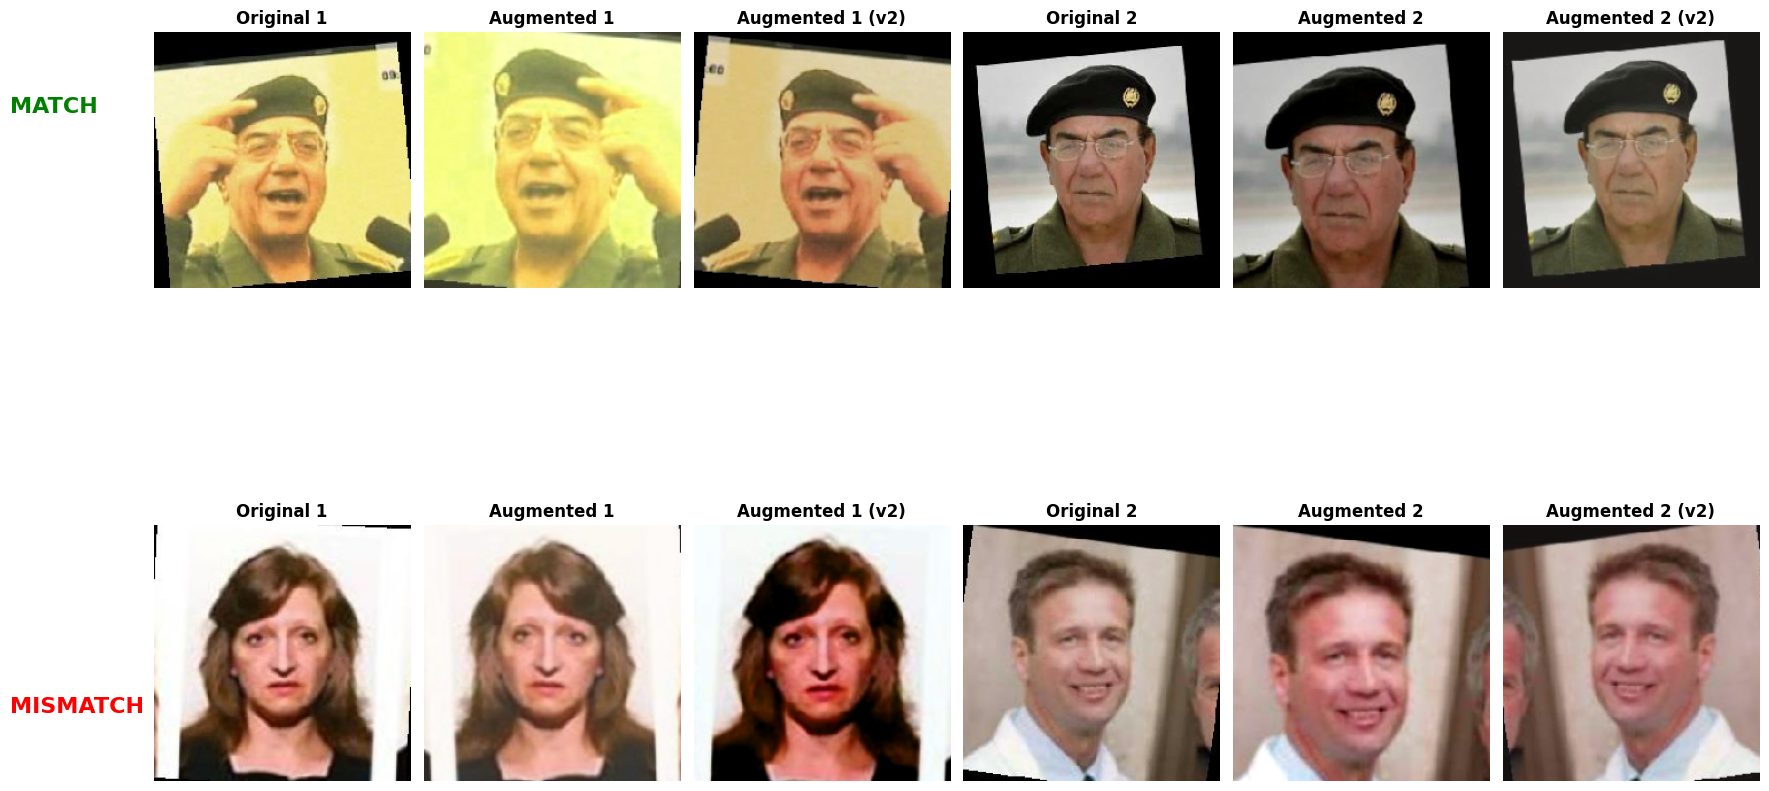

In [9]:
def visualize_augmentation_effects(pairs, labels, num_pairs=2):

    fig, axes = plt.subplots(num_pairs, 6, figsize=(18, 6 * num_pairs))
    if num_pairs == 1:
        axes = axes.reshape(1, 6)
    
    for i in range(num_pairs):
        if i >= len(pairs):
            break
            
        pair = pairs[i]
        label = labels[i]
        
        img1_orig = img_to_array(load_img(pair[0], target_size=IMG_SIZE)) / 255.0
        img2_orig = img_to_array(load_img(pair[1], target_size=IMG_SIZE)) / 255.0
        
        img1_aug = augment_image(tf.constant(img1_orig)).numpy()
        img2_aug = augment_image(tf.constant(img2_orig)).numpy()
        
        img1_aug2 = augment_image(tf.constant(img1_orig)).numpy()
        img2_aug2 = augment_image(tf.constant(img2_orig)).numpy()
        
        label_text = "MATCH" if label == 1 else "MISMATCH"
        color = "green" if label == 1 else "red"
        
        axes[i, 0].imshow(np.clip(img1_orig, 0, 1))
        axes[i, 0].set_title("Original 1", fontweight="bold")
        axes[i, 0].axis("off")
        
        axes[i, 1].imshow(np.clip(img1_aug, 0, 1))
        axes[i, 1].set_title("Augmented 1", fontweight="bold")
        axes[i, 1].axis("off")
        
        axes[i, 2].imshow(np.clip(img1_aug2, 0, 1))
        axes[i, 2].set_title("Augmented 1 (v2)", fontweight="bold")
        axes[i, 2].axis("off")
        
        axes[i, 3].imshow(np.clip(img2_orig, 0, 1))
        axes[i, 3].set_title("Original 2", fontweight="bold")
        axes[i, 3].axis("off")
        
        axes[i, 4].imshow(np.clip(img2_aug, 0, 1))
        axes[i, 4].set_title("Augmented 2", fontweight="bold")
        axes[i, 4].axis("off")
        
        axes[i, 5].imshow(np.clip(img2_aug2, 0, 1))
        axes[i, 5].set_title("Augmented 2 (v2)", fontweight="bold")
        axes[i, 5].axis("off")
        
        for j in range(6):
            for spine in axes[i, j].spines.values():
                spine.set_visible(True)
                spine.set_edgecolor(color)
                spine.set_linewidth(2)
        
        fig.text(
            0.02, 1 - (i + 0.5) / num_pairs,
            f"{label_text}",
            ha="left", va="center",
            fontsize=16, fontweight="bold",
            color=color, transform=fig.transFigure
        )
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.1)
    plt.show()


def visualize_augmented_batch(dataset, num_pairs_to_show=3):
    for batch_pairs, batch_labels in dataset.take(1):
        img1_batch, img2_batch = batch_pairs
        
        n = min(num_pairs_to_show, len(batch_labels))
        
        fig, axes = plt.subplots(n, 2, figsize=(10, n * 3))
        if n == 1:
            axes = axes.reshape(1, 2)
        
        for i in range(n):
            img1 = img1_batch[i].numpy()
            img2 = img2_batch[i].numpy()
            
            img1_display = img1 + [103.939, 116.779, 123.68]
            img2_display = img2 + [103.939, 116.779, 123.68]
            img1_display = np.clip(img1_display / 255.0, 0, 1)
            img2_display = np.clip(img2_display / 255.0, 0, 1)
            
            label = int(batch_labels[i].numpy())
            label_text = "MATCH" if label == 1 else "MISMATCH"
            color = "green" if label == 1 else "red"
            
            axes[i, 0].imshow(img1_display)
            axes[i, 0].axis("off")
            
            axes[i, 1].imshow(img2_display)
            axes[i, 1].axis("off")
            
            for ax in [axes[i, 0], axes[i, 1]]:
                for spine in ax.spines.values():
                    spine.set_visible(True)
                    spine.set_edgecolor(color)
                    spine.set_linewidth(3)
            
            fig.text(
                0.5, 1 - (i + 0.5) / n,
                f"{label_text} (Augmented)",
                ha="center", va="center",
                fontsize=14, fontweight="bold",
                color=color, transform=fig.transFigure
            )
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()
        
        print(f"Batch size: {len(batch_labels)}")
        print(f"Image shapes: {img1_batch.shape}")
        print(f"Labels: {batch_labels.numpy().flatten()}")
        break


print("=== AUGMENTATION DEMONSTRATION ===")
random_indices = random.sample(range(len(all_pairs)), 2)
demo_pairs = [all_pairs[i] for i in random_indices]
demo_labels = [all_labels[i] for i in random_indices]

visualize_augmentation_effects(demo_pairs, demo_labels, num_pairs=2)

In [10]:
from sklearn.model_selection import train_test_split
train_pairs, validation_pairs, train_labels, validation_labels = train_test_split(
    all_pairs, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)
validation_pairs, test_pairs, validation_labels, test_labels = train_test_split(
    validation_pairs, validation_labels, test_size=0.5, random_state=42, stratify=validation_labels
)
print(f"Train pairs: {len(train_pairs)}, Validation pairs: {len(validation_pairs)}, Test pairs: {len(test_pairs)}")
print(f"Train matches: {sum(train_labels)}, Validation matches: {sum(validation_labels)}, Test matches: {sum(test_labels)}")
print(f"Train mismatches: {len(train_labels) - sum(train_labels)}, Validation mismatches: {len(validation_labels) - sum(validation_labels)}, Test mismatches: {len(test_labels) - sum(test_labels)}")

Train pairs: 2560, Validation pairs: 320, Test pairs: 320
Train matches: 1280, Validation matches: 160, Test matches: 160
Train mismatches: 1280, Validation mismatches: 160, Test mismatches: 160


In [11]:
train_dataset = create_tf_dataset_optimized(
    train_pairs, train_labels, batch_size=BATCH_SIZE, shuffle=True, augment=False
)
validation_dataset = create_tf_dataset_optimized(
    validation_pairs, validation_labels, batch_size=BATCH_SIZE, shuffle=False, augment=False
)
test_dataset = create_tf_dataset_optimized(
    test_pairs, test_labels, batch_size=BATCH_SIZE, shuffle=False, augment=False
)

=== ORIGINAL TRAINING BATCH (WITHOUT AUGMENTATION) ===


/tmp/ipykernel_36/2953243306.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(batch_labels[i].numpy())


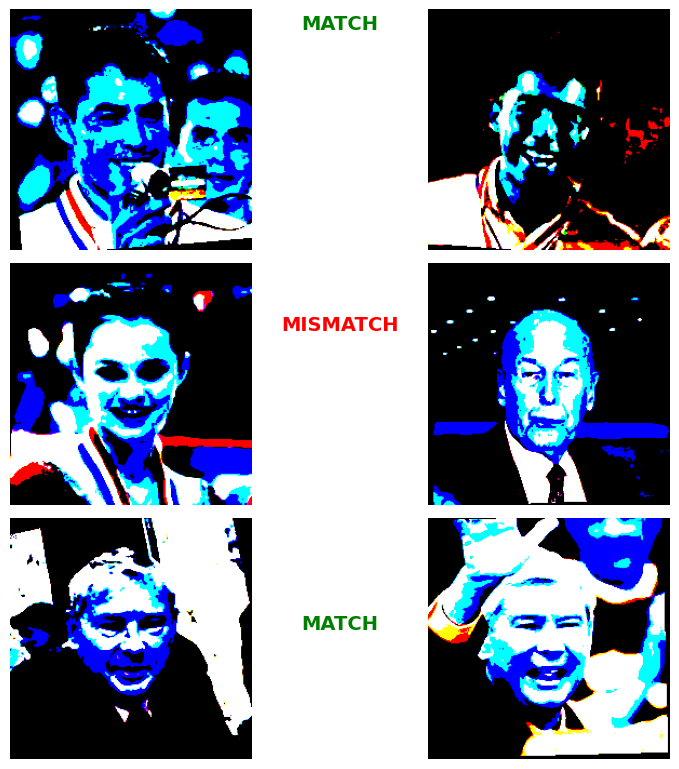

Batch size: 128
Image shapes: (128, 224, 224, 3)
Labels: [1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1.
 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 1. 1. 1. 0. 0. 0.]

=== AUGMENTED TRAINING BATCH ===


/tmp/ipykernel_36/1051578508.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(batch_labels[i].numpy())


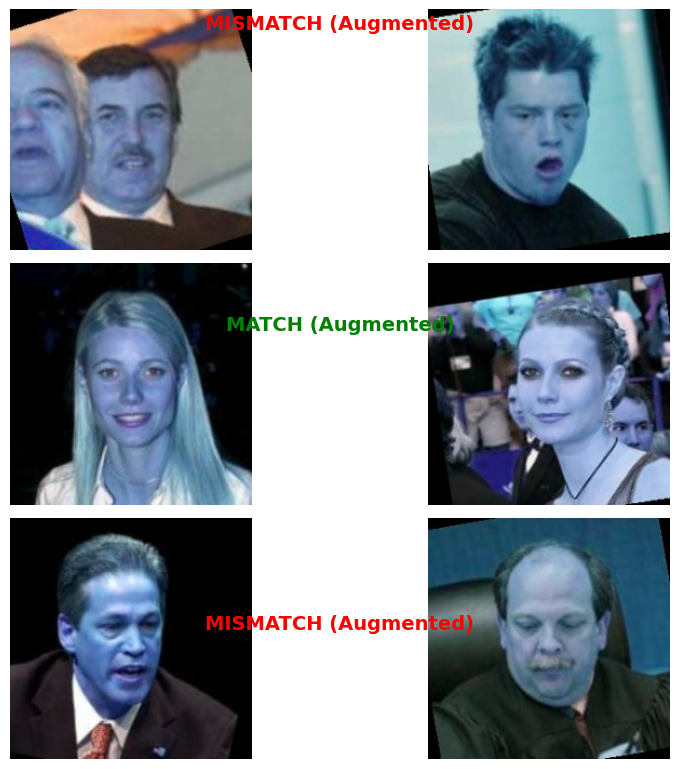

Batch size: 128
Image shapes: (128, 224, 224, 3)
Labels: [0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0.
 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1.
 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 0. 1.]


In [12]:
print("=== ORIGINAL TRAINING BATCH (WITHOUT AUGMENTATION) ===")
train_dataset_no_aug = create_tf_dataset_optimized(
    train_pairs, train_labels, batch_size=BATCH_SIZE, shuffle=True, augment=False
)
visualize_single_batch(train_dataset_no_aug, num_pairs_to_show=3)

print("\n=== AUGMENTED TRAINING BATCH ===")
visualize_augmented_batch(train_dataset, num_pairs_to_show=3)

### Model building

### Utility Functions

In [13]:
def preprocess_single_image(image_path):
    img = load_and_preprocess_image(image_path)
    return np.expand_dims(img, axis=0)


def compare_faces(model, img1_path, img2_path, threshold=0.5):
    img1 = preprocess_single_image(img1_path)
    img2 = preprocess_single_image(img2_path)

    distance = model.predict([img1, img2])[0][0]

    is_same_person = distance < threshold

    return {
        "distance": distance,
        "is_same_person": is_same_person,
        "threshold": threshold,
    }


def visualize_prediction(img1_path, img2_path, result):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    img1 = np.array(load_and_preprocess_image(img1_path))
    img2 = np.array(load_and_preprocess_image(img2_path))

    ax1.imshow(np.clip(img1, 0, 1))
    ax1.set_title("Image 1", fontsize=14, fontweight="bold")
    ax1.axis("off")

    ax2.imshow(np.clip(img2, 0, 1))
    ax2.set_title("Image 2", fontsize=14, fontweight="bold")
    ax2.axis("off")

    color = "green" if result["is_same_person"] else "red"
    result_text = "SAME PERSON" if result["is_same_person"] else "DIFFERENT PERSONS"

    plt.suptitle(
        f"{result_text}\nDistance: {result['distance']:.3f}",
        fontsize=16,
        fontweight="bold",
        color=color,
    )


    for ax in (ax1, ax2):
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor(color)
            spine.set_linewidth(3)

    plt.tight_layout()
    plt.show()

In [14]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history.history["loss"], label="Training Loss")
    ax1.plot(history.history["val_loss"], label="Validation Loss")
    ax1.set_title("Model Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy
    ax2.plot(history.history["distance_ratio"], label="Training Ratio")
    ax2.plot(history.history["val_distance_ratio"], label="Validation Ratio")
    ax2.set_title("Model Distance Ratio (Neg/Pos)")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Ratio")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

 ### Metrics

In [15]:
def cosine_similarity(vectors):
    a, b = vectors
    cosine_sim = K.sum(a * b, axis=1, keepdims=True)
    return (1.0 - cosine_sim) / 2.0  # stays in [0,1]

In [16]:
def create_simple_distance_metrics():

    def mean_positive_distance(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.squeeze(y_pred)

        positive_mask = tf.cast(y_true, tf.bool)
        positive_distances = tf.boolean_mask(y_pred, positive_mask)

        return tf.reduce_mean(positive_distances)

    def mean_negative_distance(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.squeeze(y_pred)

        negative_mask = tf.logical_not(tf.cast(y_true, tf.bool))
        negative_distances = tf.boolean_mask(y_pred, negative_mask)

        return tf.reduce_mean(negative_distances)

    def distance_ratio(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.squeeze(y_pred)

        positive_mask = tf.cast(y_true, tf.bool)
        negative_mask = tf.logical_not(positive_mask)

        positive_distances = tf.boolean_mask(y_pred, positive_mask)
        negative_distances = tf.boolean_mask(y_pred, negative_mask)

        pos_mean = tf.reduce_mean(positive_distances)
        neg_mean = tf.reduce_mean(negative_distances)

        return neg_mean / (pos_mean + 1e-8)  # Avoid division by zero

    return {
        "pos_distance": mean_positive_distance,
        "neg_distance": mean_negative_distance,
        "distance_ratio": distance_ratio,
    }


simple_metrics = create_simple_distance_metrics()

In [17]:
def _vec(x):
    return tf.reshape(tf.cast(x, tf.float32), [-1])

def mean_pos_distance(y_true, y_pred):
    d = _vec(y_pred)
    y = _vec(y_true)
    mask = tf.cast(tf.equal(y, 1.0), tf.float32)
    return tf.math.divide_no_nan(tf.reduce_sum(d * mask), tf.reduce_sum(mask))

def mean_neg_distance(y_true, y_pred):
    d = _vec(y_pred)
    y = _vec(y_true)
    mask = tf.cast(tf.equal(y, 0.0), tf.float32)
    return tf.math.divide_no_nan(tf.reduce_sum(d * mask), tf.reduce_sum(mask))

def distance_ratio(y_true, y_pred):
    pos = mean_pos_distance(y_true, y_pred)
    neg = mean_neg_distance(y_true, y_pred)
    return tf.math.divide_no_nan(neg, pos)

## Siamese Architecture

In [18]:
def create_pretrained_base_network(input_shape):
    input_layer = Input(shape=input_shape)
    
    backbone = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=input_shape)
    
    x = backbone(input_layer)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization(name="bn_pool")(x)
    x = tf.keras.layers.Dense(254, activation="relu", name="proj")(x)
    x = tf.keras.layers.BatchNormalization(name="bn_proj")(x)
    x = tf.keras.layers.Dropout(0.7)(x)
    emb = tf.keras.layers.Dense(128, use_bias=False, name="embeddings")(x)
    emb = tf.keras.layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1), name="l2_norm")(emb)
    
    base_model = tf.keras.Model(input_layer, emb, name="encoder")
        
    return base_model

    
def create_pretrained_base_network_v2(input_shape):
    input_layer = Input(shape=input_shape)
    
    backbone = tf.keras.applications.ResNet50(
        include_top=False, 
        weights="imagenet", 
        input_shape=input_shape
    )
    
    # Freeze early layers, unfreeze later layers for fine-tuning
    for layer in backbone.layers[:-10]:  # Freeze all but last ~10 layers
        layer.trainable = False
    
    x = backbone(input_layer)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization(name="bn_pool")(x)
    
    x = tf.keras.layers.Dense(512, activation="relu", name="fc1")(x)
    x = tf.keras.layers.BatchNormalization(name="bn_fc1")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(256, activation="relu", name="proj")(x)
    x = tf.keras.layers.BatchNormalization(name="bn_proj")(x)
    x = tf.keras.layers.Dropout(0.6)(x)
    
    emb = tf.keras.layers.Dense(128, use_bias=False, name="embeddings")(x)
    
    emb = tf.keras.layers.Lambda(
        lambda t: tf.math.l2_normalize(t, axis=1), 
        name="l2_norm"
    )(emb)
    
    base_model = tf.keras.Model(input_layer, emb, name="encoder")
    
    return base_model

In [19]:
def create_siamese_network(input_shape):
    base_network = create_pretrained_base_network_v2(input_shape)

    input_a = Input(shape=input_shape, name="left_input")
    input_b = Input(shape=input_shape, name="right_input")

    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    distance = Lambda(
        cosine_similarity,
        output_shape=lambda shapes: (shapes[0][0], 1),
        name="cosine_similarity",
    )([processed_a, processed_b])

    model = Model([input_a, input_b], distance, name="simple_siamese_network")
    return model, base_network

input_shape = (*IMG_SIZE, 3)
cosine_siamese_model, base_model = create_siamese_network(input_shape)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Losses

In [20]:
def contrastive_loss(y_true, y_pred, margin=0.6):
        d = _vec(y_pred)  # (B,)
        y = _vec(y_true)  # (B,)
        pos = y * tf.square(d)
        neg = (1.0 - y) * tf.square(tf.nn.relu(margin - d))
        return tf.reduce_mean(pos + neg)

In [21]:
class FocalContrastiveLoss(tf.keras.losses.Loss):
    """
    Focal Contrastive Loss for Siamese Networks.
    Focuses on hard examples and reduces false positives.
    
    Args:
        margin: Margin for negative pairs (typically 0.5-2.0)
        gamma_pos: Focusing parameter for positive pairs (2.0-5.0)
        gamma_neg: Focusing parameter for negative pairs (2.0-5.0)
        alpha_pos: Weight for positive pairs (increase if too many false negatives)
        alpha_neg: Weight for negative pairs (increase if too many false positives)
    """
    def __init__(self, margin=1.0, gamma_pos=2.0, gamma_neg=2.0, 
                 alpha_pos=0.25, alpha_neg=0.75, name='focal_contrastive_loss'):
        super().__init__(name=name)
        self.margin = margin
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.alpha_pos = alpha_pos  # Lower since you have more false positives
        self.alpha_neg = alpha_neg  # Higher to penalize false positives more
    
    def call(self, y_true, y_pred):
        """
        Args:
            y_true: Ground truth labels (1 for same, 0 for different)
            y_pred: Predicted distances from siamese network
        """
        # Ensure proper shape
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
        distances = tf.reshape(y_pred, [-1])
        
        # POSITIVE PAIRS (y_true = 1, same class)
        # We want distance -> 0
        # Focal weight increases for hard positives (large distances)
        pos_focal_weight = tf.pow(distances, self.gamma_pos)
        pos_loss = y_true * self.alpha_pos * pos_focal_weight * tf.square(distances)
        
        # NEGATIVE PAIRS (y_true = 0, different class)
        # We want distance > margin
        # Focal weight increases for hard negatives (small distances)
        neg_distance_from_margin = tf.nn.relu(self.margin - distances)
        # Normalize by margin to get weight in [0, 1]
        neg_focal_weight = tf.pow(neg_distance_from_margin / (self.margin + 1e-7), self.gamma_neg)
        neg_loss = (1.0 - y_true) * self.alpha_neg * neg_focal_weight * tf.square(neg_distance_from_margin)
        
        # Total loss
        loss = pos_loss + neg_loss
        
        return tf.reduce_mean(loss)

In [22]:

class WarmupCosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr=1e-4, warmup_steps=100, total_steps=1000, min_lr=1e-7):
        super().__init__()
        self.initial_lr = tf.constant(initial_lr, dtype=tf.float32)
        self.warmup_steps = tf.constant(warmup_steps, dtype=tf.float32)
        self.total_steps = tf.constant(total_steps, dtype=tf.float32)
        self.min_lr = tf.constant(min_lr, dtype=tf.float32)
        self.pi = tf.constant(3.14159265359, dtype=tf.float32)
    
    def __call__(self, step):
        
        step = tf.cast(step, tf.float32)
        
        warmup_lr = self.initial_lr * (step / self.warmup_steps)
        
        decay_steps = tf.maximum(self.total_steps - self.warmup_steps, 1.0)
        progress = (step - self.warmup_steps) / decay_steps
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        
        cosine_decay = 0.5 * (1.0 + tf.cos(self.pi * progress))
        cosine_lr = (self.initial_lr - self.min_lr) * cosine_decay + self.min_lr
        
        return tf.cond(
            step < self.warmup_steps,
            lambda: warmup_lr,
            lambda: cosine_lr
        )
    
    def get_config(self):
        return {
            "initial_lr": float(self.initial_lr.numpy() if hasattr(self.initial_lr, 'numpy') else self.initial_lr),
            "warmup_steps": float(self.warmup_steps.numpy() if hasattr(self.warmup_steps, 'numpy') else self.warmup_steps),
            "total_steps": float(self.total_steps.numpy() if hasattr(self.total_steps, 'numpy') else self.total_steps),
            "min_lr": float(self.min_lr.numpy() if hasattr(self.min_lr, 'numpy') else self.min_lr)
        }

In [23]:
lr_scheduler = WarmupCosineSchedule()
loss = FocalContrastiveLoss()

cosine_siamese_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(lr_scheduler),
    loss=loss,
    metrics=[mean_pos_distance, mean_neg_distance, distance_ratio],
)

Starting training...
Epoch 1/50


I0000 00:00:1758662886.197027     100 service.cc:148] XLA service 0x79ed58040470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758662886.198210     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758662886.198234     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758662890.206297     100 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758662907.560623     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - distance_ratio: 1.0272 - loss: 0.0327 - mean_neg_distance: 0.5008 - mean_pos_distance: 0.4877 - val_distance_ratio: 1.2183 - val_loss: 0.0748 - val_mean_neg_distance: 0.3464 - val_mean_pos_distance: 0.2844
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 694ms/step - distance_ratio: 1.0157 - loss: 0.0327 - mean_neg_distance: 0.4992 - mean_pos_distance: 0.4916 - val_distance_ratio: 1.1792 - val_loss: 0.0635 - val_mean_neg_distance: 0.3779 - val_mean_pos_distance: 0.3210
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 717ms/step - distance_ratio: 1.0238 - loss: 0.0330 - mean_neg_distance: 0.5028 - mean_pos_distance: 0.4912 - val_distance_ratio: 1.1766 - val_loss: 0.0664 - val_mean_neg_distance: 0.3710 - val_mean_pos_distance: 0.3163
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 739ms/step - distance_ratio: 1.0254 - loss: 0.0323 - mean_neg_distance: 0.5025 - mean_pos_distance: 0.4901 - val_distance_ratio: 1.1791 - val_loss: 0.0638 - val_mean_neg_distance: 0.3788 - 

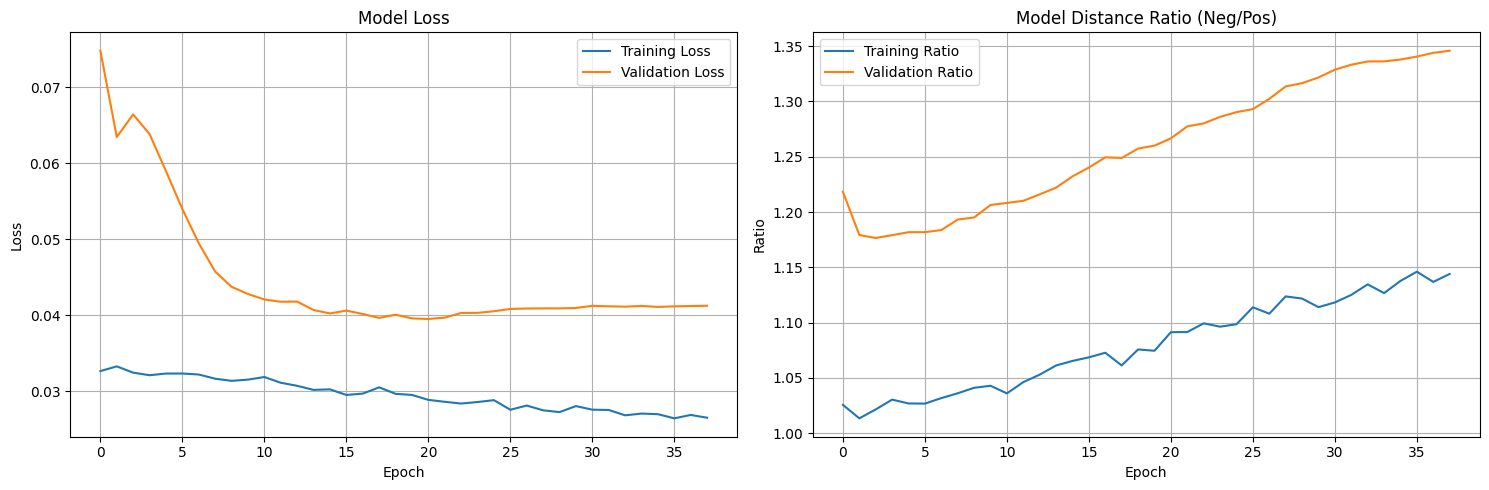

In [24]:
EPOCHS = 50

print("Starting training...")

history_1 = cosine_siamese_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=validation_dataset,
    verbose=1,
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True, min_delta=1e-3, verbose=True),
    ]
)

print("Training completed!")
plot_training_history(history_1)

In [25]:
# Save the model
import os

os.makedirs("models", exist_ok=True)

model_save_path = "models/resnet_cosine_siamese_model.keras"
cosine_siamese_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/resnet_cosine_siamese_model.keras


### Model Evaluation

In [26]:
def evaluate_model(model, test_dataset, threshold=0.5):
    predictions = model.predict(test_dataset)

    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    predicted_labels = (predictions.flatten() < threshold).astype(int)

    accuracy = accuracy_score(true_labels, predicted_labels)
    report = classification_report(
        true_labels, predicted_labels, target_names=["Different", "Same"]
    )

    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    return predictions, true_labels, predicted_labels

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def find_optimal_threshold_roc(model, test_dataset):
    predictions = model.predict(test_dataset)

    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    distances = predictions.flatten()

    similarities = 1 - distances

    fpr, tpr, thresholds = roc_curve(true_labels, similarities)
    roc_auc = auc(fpr, tpr)

    # Youden's J statistic
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold_similarity = thresholds[optimal_idx]
    optimal_threshold_distance = 1 - optimal_threshold_similarity

    plt.figure(figsize=(8, 6))
    plt.plot(
        fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})"
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.scatter(
        fpr[optimal_idx],
        tpr[optimal_idx],
        color="red",
        s=100,
        label=f"Optimal threshold = {optimal_threshold_distance:.3f}",
    )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Threshold Selection")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return optimal_threshold_distance, roc_auc

In [28]:
def find_threshold_by_accuracy(model, test_dataset, threshold_range=(0.1, 1.5, 100)):
    predictions = model.predict(test_dataset)

    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    distances = predictions.flatten()

    thresholds = np.linspace(threshold_range[0], threshold_range[1], threshold_range[2])
    accuracies = []

    for threshold in thresholds:
        predicted_labels = (distances < threshold).astype(int)
        accuracy = accuracy_score(true_labels, predicted_labels)
        accuracies.append(accuracy)

    best_idx = np.argmax(accuracies)
    best_threshold = thresholds[best_idx]
    best_accuracy = accuracies[best_idx]


    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, accuracies, "b-", linewidth=2)
    plt.scatter(best_threshold, best_accuracy, color="red", s=100, zorder=5)
    plt.xlabel("Threshold")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Threshold")
    plt.grid(True)
    plt.axvline(
        x=best_threshold,
        color="red",
        linestyle="--",
        alpha=0.7,
        label=f"Best threshold: {best_threshold:.3f} (Acc: {best_accuracy:.3f})",
    )
    plt.legend()
    plt.show()

    return best_threshold, best_accuracy

In [29]:
def find_eer_threshold(model, test_dataset):
    predictions = model.predict(test_dataset)

    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    distances = predictions.flatten()


    similarities = 1 - distances
    fpr, tpr, thresholds = roc_curve(true_labels, similarities)
    fnr = 1 - tpr  # False Negative Rate


    eer_idx = np.argmin(np.abs(fpr - fnr))
    eer_threshold_similarity = thresholds[eer_idx]
    eer_threshold_distance = 1 - eer_threshold_similarity
    eer_rate = (fpr[eer_idx] + fnr[eer_idx]) / 2


    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, fpr, label="False Positive Rate", color="red")
    plt.plot(thresholds, fnr, label="False Negative Rate", color="blue")
    plt.axvline(
        x=eer_threshold_similarity,
        color="green",
        linestyle="--",
        label=f"EER Threshold: {eer_threshold_distance:.3f}",
    )
    plt.xlabel("Threshold (Similarity)")
    plt.ylabel("Error Rate")
    plt.title(f"Equal Error Rate (EER = {eer_rate:.3f})")
    plt.legend()
    plt.grid(True)
    plt.show()

    return eer_threshold_distance, eer_rate

In [30]:
from sklearn.metrics import precision_recall_curve


def find_threshold_precision_recall_robust(model, test_dataset, target_precision=0.95):
    predictions = model.predict(test_dataset)

    true_labels = []
    for _, labels in test_dataset:
        true_labels.extend(labels.numpy().flatten())

    true_labels = np.array(true_labels)
    distances = predictions.flatten()
    similarities = 1 - distances


    precision, recall, thresholds = precision_recall_curve(true_labels, similarities)

    print(
        f"Shapes: precision={precision.shape}, recall={recall.shape}, thresholds={thresholds.shape}"
    )

    if len(precision) == len(thresholds) + 1:
        precision = precision[:-1]
        recall = recall[:-1]

    target_idx = np.where(precision >= target_precision)[0]

    if len(target_idx) > 0:
        best_local_idx = np.argmax(recall[target_idx])
        best_idx = target_idx[best_local_idx]

        if best_idx < len(thresholds):  # Safety check
            target_threshold_similarity = thresholds[best_idx]
            target_threshold_distance = 1 - target_threshold_similarity
            achieved_precision = precision[best_idx]
            achieved_recall = recall[best_idx]

            print(f"Found valid threshold at index {best_idx}")
            print(
                f"Achieved precision: {achieved_precision:.3f}, recall: {achieved_recall:.3f}"
            )
        else:
            print(
                f"Index {best_idx} out of bounds for thresholds array of size {len(thresholds)}"
            )
            target_threshold_distance = 0.5
            achieved_precision = target_precision
            achieved_recall = 0.0
    else:
        print(f"Warning: Could not achieve {target_precision:.2f} precision.")
        print(f"Maximum achieved precision: {precision.max():.3f}")
        target_threshold_distance = 0.1  # Very conservative threshold
        achieved_precision = precision.max()
        achieved_recall = recall[np.argmax(precision)]

    precision_orig, recall_orig, _ = precision_recall_curve(true_labels, similarities)
    plt.figure(figsize=(10, 6))
    plt.plot(recall_orig, precision_orig, "b-", linewidth=2, label="PR Curve")
    plt.axhline(
        y=target_precision,
        color="red",
        linestyle="--",
        label=f"Target Precision: {target_precision}",
    )

    if len(target_idx) > 0 and best_idx < len(thresholds):
        plt.scatter(
            achieved_recall,
            achieved_precision,
            color="red",
            s=100,
            zorder=5,
            label=f"Selected: P={achieved_precision:.3f}, R={achieved_recall:.3f}",
        )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()

    return target_threshold_distance

=== COMPREHENSIVE THRESHOLD ANALYSIS ===

1. ROC Curve Analysis:
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step 


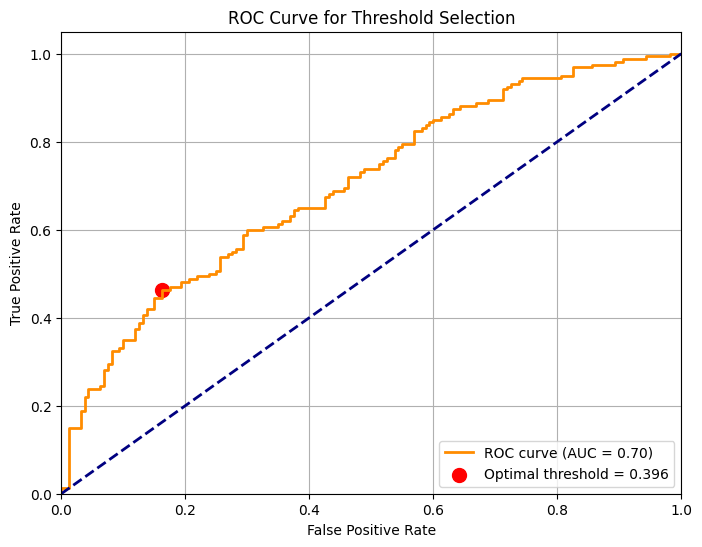

   Optimal threshold: 0.396
   AUC Score: 0.702

2. Accuracy Maximization:
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step


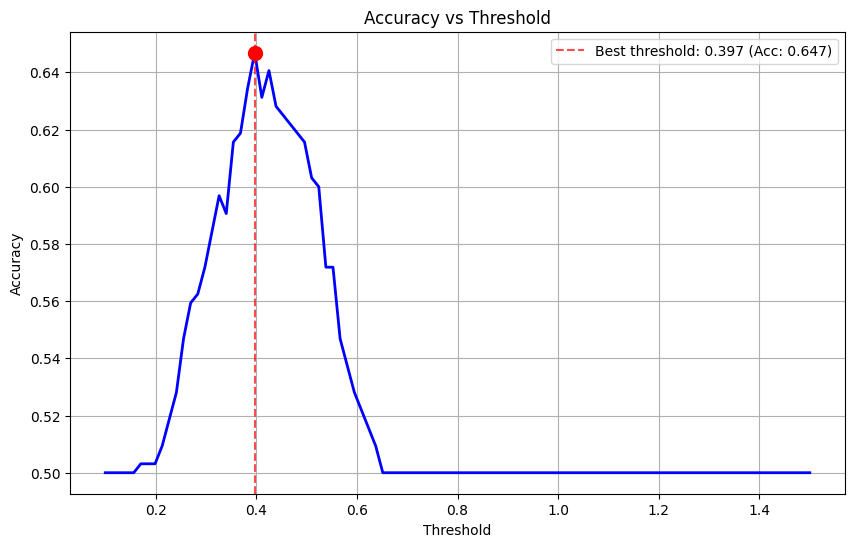

   Best threshold: 0.397
   Best accuracy: 0.647

3. Equal Error Rate:
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 501ms/step


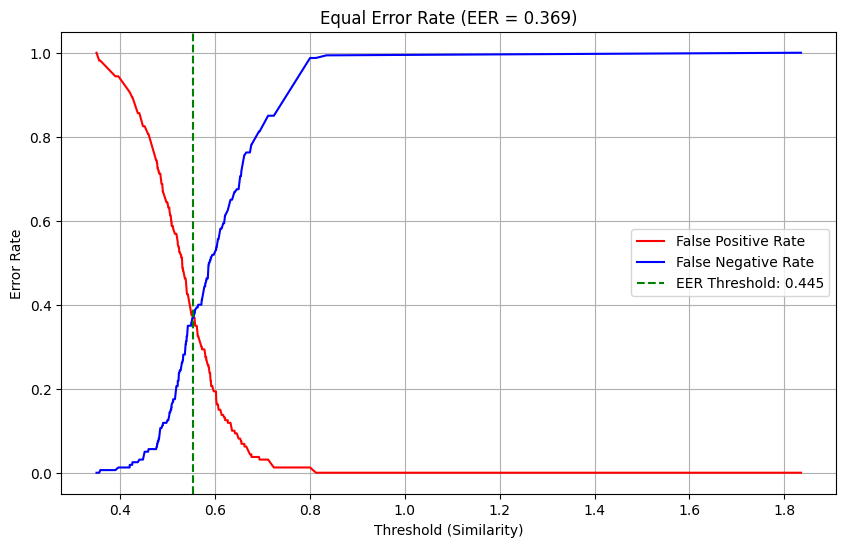

   EER threshold: 0.445
   EER rate: 0.369

4. High Precision (95%):
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 508ms/step
Shapes: precision=(321,), recall=(321,), thresholds=(320,)
Found valid threshold at index 318
Achieved precision: 1.000, recall: 0.013


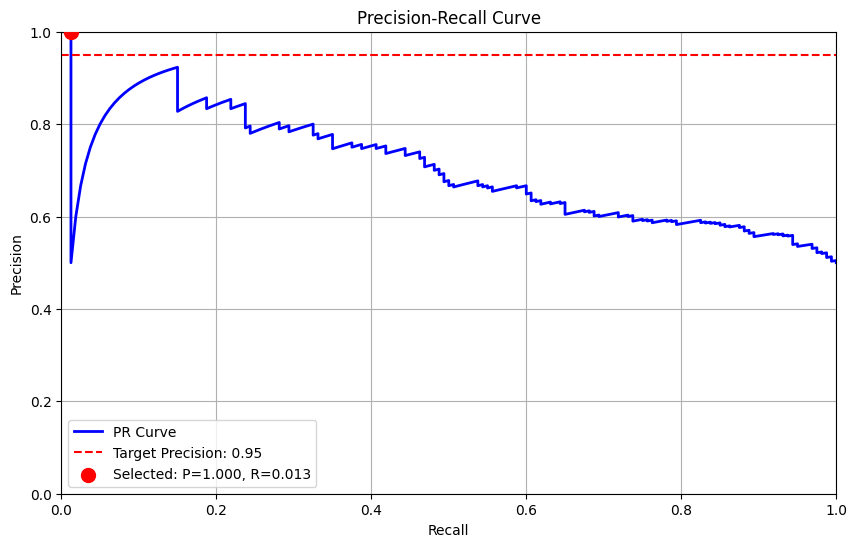

   Threshold: 0.187

=== SUMMARY ===
ROC Optimal:     0.396
Max Accuracy:    0.397
EER:             0.445
95% Precision:   0.187


In [31]:
def comprehensive_threshold_analysis(model, test_dataset):

    print("=== COMPREHENSIVE THRESHOLD ANALYSIS ===\n")

    print("1. ROC Curve Analysis:")
    roc_threshold, auc_score = find_optimal_threshold_roc(model, test_dataset)
    print(f"   Optimal threshold: {roc_threshold:.3f}")
    print(f"   AUC Score: {auc_score:.3f}\n")

    print("2. Accuracy Maximization:")
    acc_threshold, best_acc = find_threshold_by_accuracy(model, test_dataset)
    print(f"   Best threshold: {acc_threshold:.3f}")
    print(f"   Best accuracy: {best_acc:.3f}\n")

    print("3. Equal Error Rate:")
    eer_threshold, eer_rate = find_eer_threshold(model, test_dataset)
    print(f"   EER threshold: {eer_threshold:.3f}")
    print(f"   EER rate: {eer_rate:.3f}\n")

    print("4. High Precision (95%):")
    pr_threshold = find_threshold_precision_recall_robust(model, test_dataset, 0.95)
    print(f"   Threshold: {pr_threshold:.3f}\n")

    print("=== SUMMARY ===")
    print(f"ROC Optimal:     {roc_threshold:.3f}")
    print(f"Max Accuracy:    {acc_threshold:.3f}")
    print(f"EER:             {eer_threshold:.3f}")
    print(f"95% Precision:   {pr_threshold:.3f}")

    return roc_threshold


recommended_threshold = comprehensive_threshold_analysis(
    cosine_siamese_model, test_dataset
)

In [32]:
test_predictions, test_true, test_pred = evaluate_model(
    cosine_siamese_model, test_dataset, threshold=recommended_threshold
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 516ms/step
Test Accuracy: 0.6469

Classification Report:
              precision    recall  f1-score   support

   Different       0.61      0.84      0.70       160
        Same       0.74      0.46      0.56       160

    accuracy                           0.65       320
   macro avg       0.67      0.65      0.63       320
weighted avg       0.67      0.65      0.63       320



# Knowledge distillation

In [33]:
teacher_model_path = Path("/kaggle/working/models/resnet_cosine_siamese_model.keras")
assert teacher_model_path.exists()

In [34]:
input_shape = (*IMG_SIZE, 3)


# teacher_model, _ = create_siamese_network_local_weights(input_shape, weights_path)
teacher_model, _ = create_siamese_network(input_shape)

try:
    teacher_model.load_weights(teacher_model_path)
    print("Weights loaded successfully!")
except Exception as e:
    print(f"Error loading weights: {e}")

Weights loaded successfully!


In [35]:
teacher_model.summary()

Model: "simple_siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ left_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ right_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ (None, 128)       │ 24,812,160 │ left_input[0][0], │
│ (Functional)        │                   │            │ right_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cosine_similarity   │ (None, 1)         │          0 │ encoder[0][0],    │
│ (Lambda)            │                   │            │ encoder[1][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,812,160 (94.65 MB)

 Trainable params: 5,684,480 (21.68 MB)

 Non-trainable params: 19,127,680 (72.97 MB)

In [36]:
def extract_teacher_encoder(siamese_model):
    for layer in siamese_model.layers:
        if "encoder" in layer.name:
            teacher_encoder = layer
            break
    else:
        raise Exception("Encoder not found")

    print(f"Teacher encoder: {teacher_encoder.name}")
    print(f"Teacher parameters: {teacher_encoder.count_params():,}")
    return teacher_encoder


teacher_encoder = extract_teacher_encoder(teacher_model)

Teacher encoder: encoder
Teacher parameters: 24,812,160


In [37]:
teacher_encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_pool (BatchNormalization)    │ (None, 2048)           │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_fc1 (BatchNormalization)     │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ proj (Dense)                    │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_proj (BatchNormalization)    │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embeddings (Dense)              │ (None, 128)            │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_norm (Lambda)                │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,812,160 (94.65 MB)

 Trainable params: 5,684,480 (21.68 MB)

 Non-trainable params: 19,127,680 (72.97 MB)

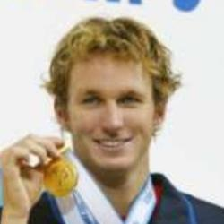

In [38]:
random_image = all_pairs[0][0]
img = load_img(random_image, target_size=IMG_SIZE)
img

In [39]:
img = np.expand_dims(img_to_array(img), axis=0)
print(f"Shape of image {img.shape}")

Shape of image (1, 224, 224, 3)


In [40]:
embedding = teacher_encoder.predict(img)
print(f"Size of embedding {embedding.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Size of embedding (1, 128)


In [41]:
preprocess_image = decode_and_preprocess(str(random_image))
embedding_preprocess = teacher_encoder.predict(np.expand_dims(preprocess_image, axis=0))
embedding_preprocess.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


(1, 128)

In [42]:
np.linalg.norm(embedding - embedding_preprocess)

0.9937909

In [43]:
def create_micro_encoder(input_shape=(96, 96, 3), embedding_size=128,):
    
    inputs = Input(shape=input_shape)
    
    x = Conv2D(8, 3, strides=2, padding='same', activation='relu')(inputs)
    x = Conv2D(16, 3, strides=2, padding='same', activation='relu')(x)
    x = Conv2D(32, 3, strides=2, padding='same', activation='relu')(x)
    x = Conv2D(64, 3, strides=2, padding='same', activation='relu')(x)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(embedding_size, use_bias=False)(x)
    x = BatchNormalization()(x)
    outputs = Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(x)
    
    model = Model(inputs, outputs, name='micro_encoder')
    
    # Print model size
    params = model.count_params()
    print(f"Model parameters: {params:,}")
    print(f"Estimated size (float32): {params * 4 / 1024:.2f} KB")
    print(f"Estimated size (int8): {params / 1024:.2f} KB")
    
    return model



def create_minimal_improved_encoder(input_shape=(96, 96, 3), embedding_size=128):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(8, 3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(16, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(32, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64, 3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    
    x = Dense(embedding_size, use_bias=False)(x)
    x = BatchNormalization()(x)
    outputs = Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(x)
    
    return Model(inputs, outputs, name='minimal_improved_encoder')

In [44]:
training_images = set()
for pair in train_pairs:
    path1, path2 = pair[0], pair[1]
    training_images.add(str(path1))
    training_images.add(str(path2))
training_images = list(training_images)

validation_images = set()
for pair in validation_pairs:
    path1, path2 = pair[0], pair[1]
    validation_images.add(str(path1))
    validation_images.add(str(path2))
validation_images = list(validation_images)

test_images = set()
for pair in test_pairs:
    path1, path2 = pair[0], pair[1]
    test_images.add(str(path1))
    test_images.add(str(path2))
test_images = list(test_images)

print(f"Training images: {len(training_images)}")
print(f"Validation images: {len(validation_images)}")

Training images: 4206
Validation images: 629


In [45]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE
IMG_T = (224, 224)
IMG_S = (96, 96)
BATCH = 64

def decode_raw(path):
    bytestr = tf.io.read_file(path)
    img = tf.image.decode_image(bytestr, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_T, antialias=True)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def resize_student(img):
    return tf.image.resize(img, IMG_S, antialias=True)

def make_dataset(paths, batch_size=BATCH, training=True, resize=False):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    if training:
        ds = ds.shuffle(len(paths), reshuffle_each_iteration=True)
    ds = ds.map(decode_raw, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=not resize and training).prefetch(AUTOTUNE)
    return ds

ds_train = make_dataset(training_images, training=True,  resize=False)
ds_val   = make_dataset(validation_images, training=False, resize=False)

In [46]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_pre
import tensorflow as tf
from tensorflow.keras import layers as L

class Distiller_ContrastiveLoss(tf.keras.Model):
    def __init__(self, teacher, student, temperature=4.0, mse_weight=0.3, contrastive_weight=0.7):
        super().__init__()
        self.teacher = teacher
        self.teacher.trainable = False
        self.student = student
        self.resize_s = L.Resizing(96, 96)
        
        self.mse_weight = mse_weight
        self.contrastive_weight = contrastive_weight
        
        self.temperature = temperature
        
        self.mse = tf.keras.losses.MeanSquaredError()
        
    def contrastive_distillation_loss(self, student_embeddings, teacher_embeddings):
        batch_size = tf.shape(student_embeddings)[0]
        
        student_norm = tf.nn.l2_normalize(student_embeddings, axis=1)
        teacher_norm = tf.nn.l2_normalize(teacher_embeddings, axis=1)
        
        student_sim_matrix = tf.matmul(student_norm, student_norm, transpose_b=True)
        teacher_sim_matrix = tf.matmul(teacher_norm, teacher_norm, transpose_b=True)
        
        student_sim_scaled = student_sim_matrix / self.temperature
        teacher_sim_scaled = teacher_sim_matrix / self.temperature
        
        mask = tf.eye(batch_size, dtype=tf.bool)
        student_sim_masked = tf.where(mask, -1e9, student_sim_scaled)
        teacher_sim_masked = tf.where(mask, -1e9, teacher_sim_scaled)
        
        teacher_probs = tf.nn.softmax(teacher_sim_masked, axis=-1)
        student_log_probs = tf.nn.log_softmax(student_sim_masked, axis=-1)
        
        kl_div = tf.reduce_sum(teacher_probs * (tf.math.log(teacher_probs + 1e-8) - student_log_probs), axis=-1)
        
        contrastive_loss = tf.reduce_mean(kl_div)
        
        return contrastive_loss
    
    @tf.function
    def train_step(self, raw_x):
        t_x = resnet_pre(raw_x * 255.0)
        
        zt = self.teacher(t_x, training=False)
        
        with tf.GradientTape() as tape:
            s_x = self.resize_s(raw_x)
            zs = self.student(s_x, training=True)
            
            loss_mse = self.mse(zs, zt)
            loss_contrastive = self.contrastive_distillation_loss(zs, zt)
            
            loss = self.mse_weight * loss_mse + self.contrastive_weight * loss_contrastive
        
        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))
        
        zs_norm = tf.nn.l2_normalize(zs, axis=1)
        zt_norm = tf.nn.l2_normalize(zt, axis=1)
        cos_sim = tf.reduce_mean(tf.reduce_sum(zs_norm * zt_norm, axis=1))
        
        return {
            "loss": loss, 
            "contrastive_loss": loss_contrastive, 
            "mse_loss": loss_mse, 
            "cos_sim": cos_sim  # For monitoring only
        }
    
    @tf.function
    def test_step(self, raw_x):
        t_x = resnet_pre(raw_x * 255.0)
        s_x = self.resize_s(raw_x)
        
        zt = self.teacher(t_x, training=False)
        zs = self.student(s_x, training=False)
        
        loss_mse = self.mse(zs, zt)
        
        loss_contrastive = self.contrastive_distillation_loss(zs, zt)
        loss = self.mse_weight * loss_mse + self.contrastive_weight * loss_contrastive
        
        zs_norm = tf.nn.l2_normalize(zs, axis=1)
        zt_norm = tf.nn.l2_normalize(zt, axis=1)
        cos_sim = tf.reduce_mean(tf.reduce_sum(zs_norm * zt_norm, axis=1))
        
        return {
            "loss": loss, 
            "contrastive_loss": loss_contrastive, 
            "mse_loss": loss_mse, 
            "cos_sim": cos_sim
        }

In [47]:
callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=True)
]

In [48]:
student_model = create_minimal_improved_encoder(input_shape=(96, 96, 3), embedding_size=128)

distiller = Distiller_ContrastiveLoss(teacher_encoder, student_model)
distiller.compile(optimizer=tf.keras.optimizers.AdamW(1e-3))
history_dist = distiller.fit(ds_train, epochs=40, validation_data=ds_val, callbacks=callbacks)


Epoch 1/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 424ms/step - contrastive_loss: 8.5666e-04 - cos_sim: 0.0991 - loss: 0.0048 - mse_loss: 0.0141 - val_contrastive_loss: 5.9922e-04 - val_cos_sim: -0.2185 - val_loss: 0.0061 - val_mse_loss: 0.0190 - learning_rate: 0.0010
Epoch 2/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 213ms/step - contrastive_loss: 0.0011 - cos_sim: 0.2991 - loss: 0.0041 - mse_loss: 0.0110 - val_contrastive_loss: 0.0017 - val_cos_sim: 0.3385 - val_loss: 0.0043 - val_mse_loss: 0.0103 - learning_rate: 0.0010
Epoch 3/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 14s 207ms/step - contrastive_loss: 0.0013 - cos_sim: 0.4302 - loss: 0.0036 - mse_loss: 0.0089 - val_contrastive_loss: 8.7774e-04 - val_cos_sim: 0.2442 - val_loss: 0.0042 - val_mse_loss: 0.0118 - learning_rate: 0.0010
Epoch 4/40
65/65 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - contrastive_loss: 0.0012 - cos_sim: 0.5574 - loss: 0.0029 - mse_loss: 0.0069 - val_contrastive_loss: 3.2517e-04 - val_cos_sim: 0.7148 - val_loss: 0.0016 - val_mse_loss: 0.0045 - l

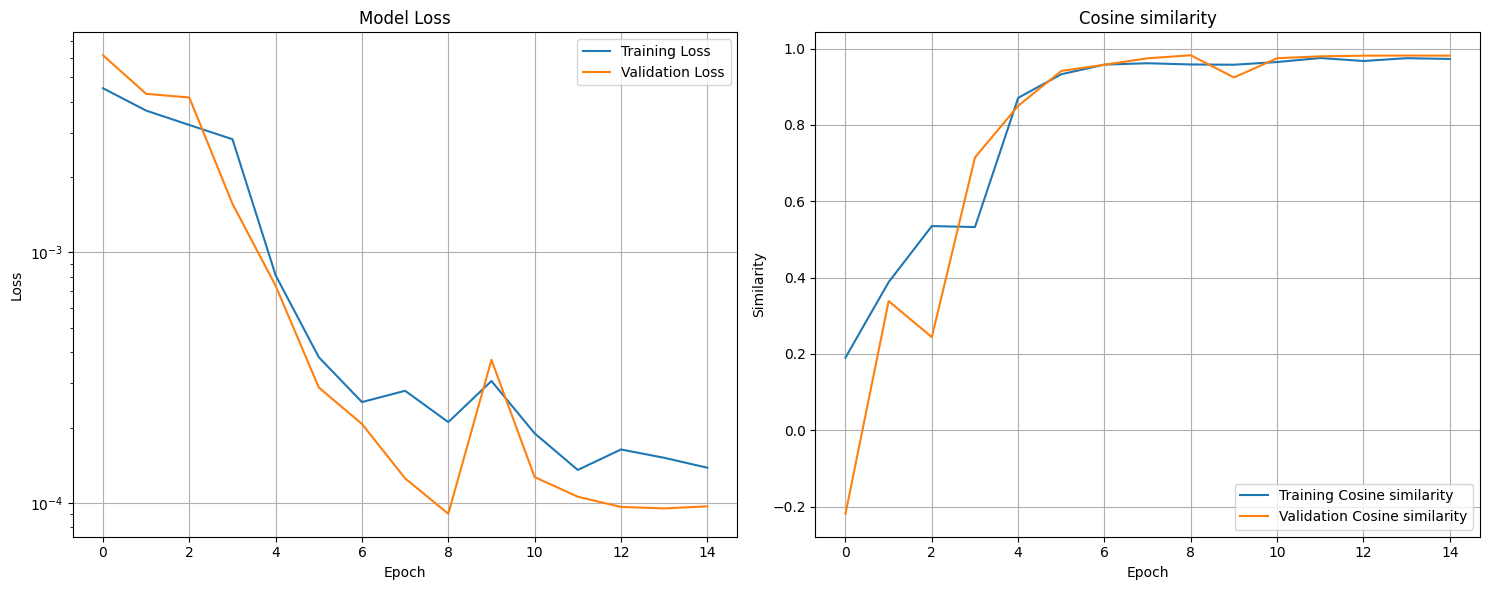

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].semilogy(history_dist.history["loss"], label="Training Loss")
axs[0].semilogy(history_dist.history["val_loss"], label="Validation Loss")
axs[0].set_title("Model Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(history_dist.history["cos_sim"], label="Training Cosine similarity")
axs[1].plot(history_dist.history["val_cos_sim"], label="Validation Cosine similarity")
axs[1].set_title("Cosine similarity")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Similarity")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

Student model saved to ./models/student_21_09.keras

STUDENT MODEL EVALUATION

Model Size Comparison:
Teacher model parameters: 24,812,160
Student model parameters: 33,712
Compression ratio: 736.0x smaller

Evaluating Models on Test Dataset...
--------------------------------------------------
Getting teacher predictions...
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step 
Getting student predictions...
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 514ms/step

FINDING OPTIMAL THRESHOLDS

Student - Optimal threshold search:
  Best threshold: 0.0033
  Best accuracy: 0.6156
  Best F1 score: 0.6350

Using thresholds:
  Teacher threshold: 0.3959
  Student threshold: 0.0033

EVALUATION RESULTS WITH SEPARATE THRESHOLDS

Teacher Model Results (threshold = 0.3959):
Test Accuracy: 0.6469

Teacher Classification Report:
              precision    recall  f1-score   support

   Different     0.6063    0.8375    0.7034       160
        Same     0.7374    0.4562    0.5637       160

    accuracy                         0.6469  

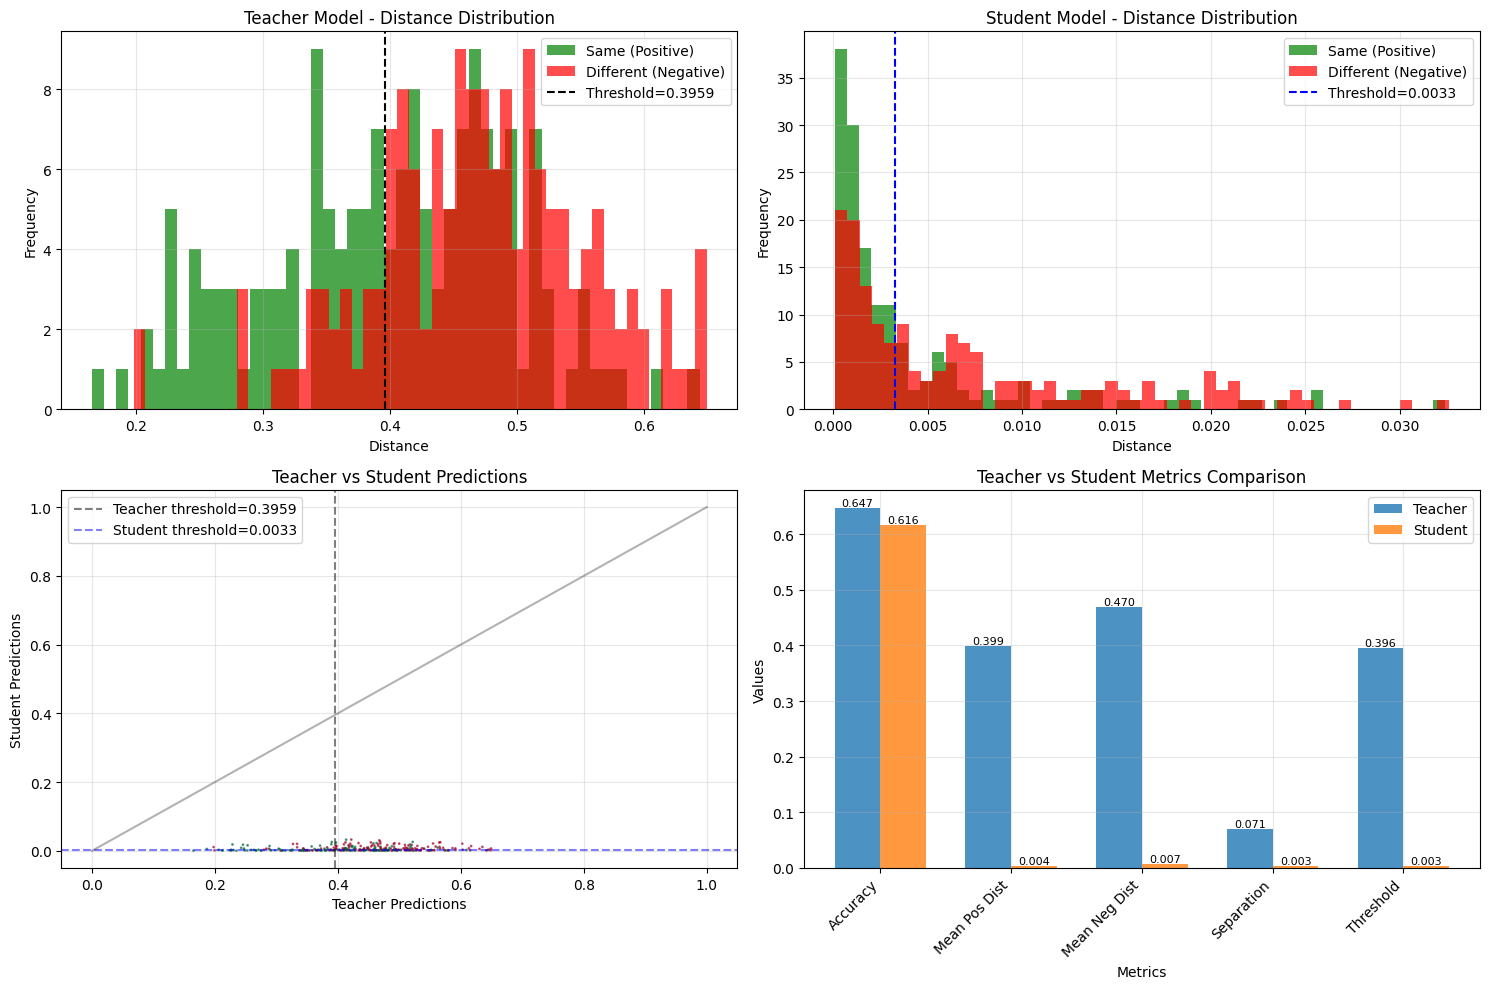

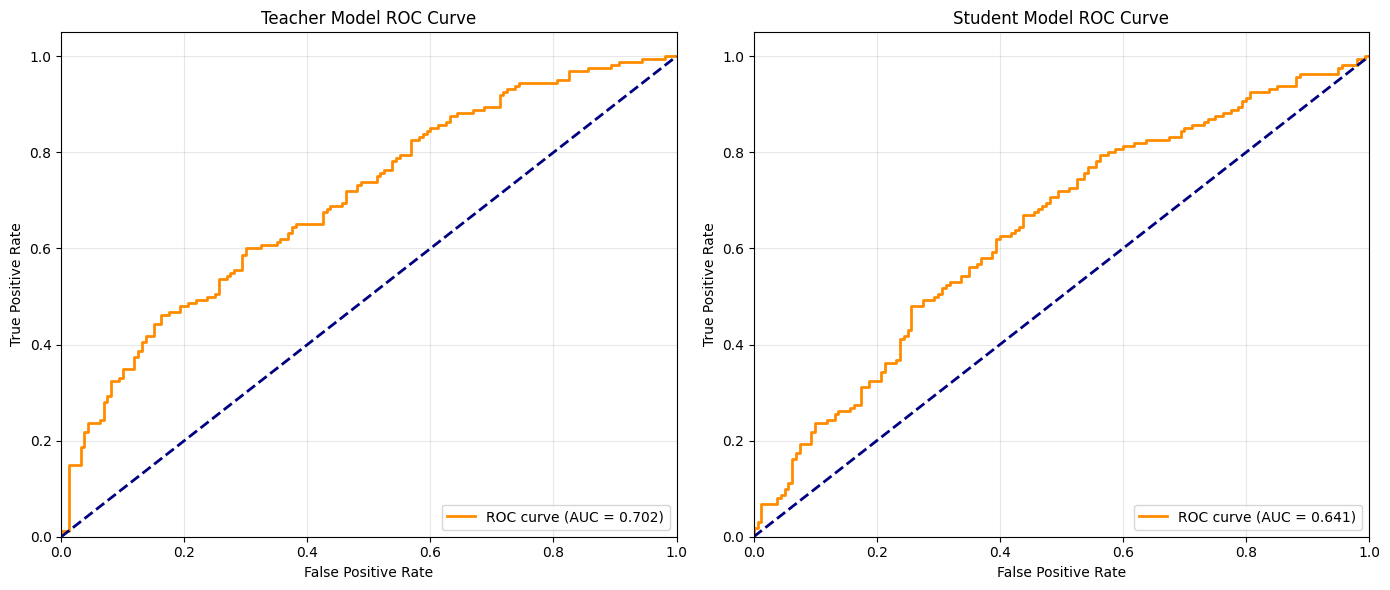


ROC AUC SCORES
Teacher ROC AUC: 0.7020
Student ROC AUC: 0.6405
AUC Difference: 0.0615

EVALUATION COMPLETE


In [50]:
# Evaluate the student model and get accuracies on test datasets

student_save_path = "./models/student_21_09.keras"
student_model.save(student_save_path)
print(f"Student model saved to {student_save_path}")

print("\n" + "="*60)
print("STUDENT MODEL EVALUATION")
print("="*60)

print(f"\nModel Size Comparison:")
teacher_params = teacher_encoder.count_params()
student_params = student_model.count_params()
print(f"Teacher model parameters: {teacher_params:,}")
print(f"Student model parameters: {student_params:,}")
print(f"Compression ratio: {teacher_params/student_params:.1f}x smaller")

def create_student_siamese_network(student_encoder, input_shape):
    input_a = Input(shape=input_shape, name="left_input")
    input_b = Input(shape=input_shape, name="right_input") 
    
    resized_a = tf.keras.layers.Resizing(96, 96)(input_a)
    resized_b = tf.keras.layers.Resizing(96, 96)(input_b)
    
    processed_a = student_encoder(resized_a)
    processed_b = student_encoder(resized_b)
    
    distance = Lambda(
        cosine_similarity,
        output_shape=lambda shapes: (shapes[0][0], 1),
        name="cosine_similarity"
    )([processed_a, processed_b])
    
    model = Model([input_a, input_b], distance, name="student_siamese_network")
    return model

student_siamese_model = create_student_siamese_network(student_model, input_shape)

print(f"\nEvaluating Models on Test Dataset...")
print("-" * 50)

print("Getting teacher predictions...")
teacher_predictions = teacher_model.predict(test_dataset, verbose=1)

print("Getting student predictions...")
student_predictions = student_siamese_model.predict(test_dataset, verbose=1)

true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy().flatten())
true_labels = np.array(true_labels)

def find_optimal_threshold(predictions, true_labels, model_name="Model"):
    from sklearn.metrics import accuracy_score, f1_score
    
    thresholds = np.linspace(
        0, 
        0.05, 
        10000
    )
    
    best_threshold = None
    best_accuracy = 0
    best_f1 = 0
    
    for threshold in thresholds:
        pred_labels = (predictions.flatten() < threshold).astype(int)
        accuracy = accuracy_score(true_labels, pred_labels)
        f1 = f1_score(true_labels, pred_labels)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
            best_f1 = f1
    
    print(f"\n{model_name} - Optimal threshold search:")
    print(f"  Best threshold: {best_threshold:.4f}")
    print(f"  Best accuracy: {best_accuracy:.4f}")
    print(f"  Best F1 score: {best_f1:.4f}")
    
    return best_threshold

print("\n" + "="*60)
print("FINDING OPTIMAL THRESHOLDS")
print("="*60)

teacher_threshold = recommended_threshold

student_threshold = find_optimal_threshold(student_predictions, true_labels, "Student")

print(f"\nUsing thresholds:")
print(f"  Teacher threshold: {teacher_threshold:.4f}")
print(f"  Student threshold: {student_threshold:.4f}")

teacher_pred_labels = (teacher_predictions.flatten() < teacher_threshold).astype(int)
student_pred_labels = (student_predictions.flatten() < student_threshold).astype(int)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

teacher_accuracy = accuracy_score(true_labels, teacher_pred_labels)
student_accuracy = accuracy_score(true_labels, student_pred_labels)

print(f"\n" + "="*60)
print("EVALUATION RESULTS WITH SEPARATE THRESHOLDS")
print("="*60)

# Teacher Model Results
print(f"\nTeacher Model Results (threshold = {teacher_threshold:.4f}):")
print(f"Test Accuracy: {teacher_accuracy:.4f}")

print("\nTeacher Classification Report:")
teacher_report = classification_report(
    true_labels, teacher_pred_labels, 
    target_names=["Different", "Same"],
    digits=4
)
print(teacher_report)

print("\nTeacher Confusion Matrix:")
teacher_cm = confusion_matrix(true_labels, teacher_pred_labels)
print(f"True Negatives: {teacher_cm[0,0]}, False Positives: {teacher_cm[0,1]}")
print(f"False Negatives: {teacher_cm[1,0]}, True Positives: {teacher_cm[1,1]}")

print(f"\n" + "-"*60)
print(f"\nStudent Model Results (threshold = {student_threshold:.4f}):")
print(f"Test Accuracy: {student_accuracy:.4f}")

print("\nStudent Classification Report:")
student_report = classification_report(
    true_labels, student_pred_labels, 
    target_names=["Different", "Same"],
    digits=4
)
print(student_report)

print("\nStudent Confusion Matrix:")
student_cm = confusion_matrix(true_labels, student_pred_labels)
print(f"True Negatives: {student_cm[0,0]}, False Positives: {student_cm[0,1]}")
print(f"False Negatives: {student_cm[1,0]}, True Positives: {student_cm[1,1]}")




print(f"\n" + "="*60)
print("TEACHER vs STUDENT COMPARISON")
print("="*60)

print(f"\nComparison Results:")
print(f"Teacher Accuracy: {teacher_accuracy:.4f} (threshold: {teacher_threshold:.4f})")
print(f"Student Accuracy: {student_accuracy:.4f} (threshold: {student_threshold:.4f})")
print(f"Accuracy Difference: {teacher_accuracy - student_accuracy:.4f}")
print(f"Relative Performance: {student_accuracy/teacher_accuracy*100:.1f}% of teacher")

def calculate_distance_stats(predictions, true_labels):
    distances = predictions.flatten()
    pos_mask = (true_labels == 1)
    neg_mask = (true_labels == 0)
    
    pos_distances = distances[pos_mask]
    neg_distances = distances[neg_mask]
    
    return {
        'mean_pos_dist': np.mean(pos_distances),
        'mean_neg_dist': np.mean(neg_distances),
        'std_pos_dist': np.std(pos_distances),
        'std_neg_dist': np.std(neg_distances),
        'separation': np.mean(neg_distances) - np.mean(pos_distances)
    }

teacher_stats = calculate_distance_stats(teacher_predictions, true_labels)
student_stats = calculate_distance_stats(student_predictions, true_labels)

print(f"\nDistance Statistics:")
print(f"Teacher - Mean positive distance: {teacher_stats['mean_pos_dist']:.4f} ± {teacher_stats['std_pos_dist']:.4f}")
print(f"Teacher - Mean negative distance: {teacher_stats['mean_neg_dist']:.4f} ± {teacher_stats['std_neg_dist']:.4f}")
print(f"Teacher - Separation: {teacher_stats['separation']:.4f}")
print(f"Student - Mean positive distance: {student_stats['mean_pos_dist']:.4f} ± {student_stats['std_pos_dist']:.4f}")
print(f"Student - Mean negative distance: {student_stats['mean_neg_dist']:.4f} ± {student_stats['std_neg_dist']:.4f}")
print(f"Student - Separation: {student_stats['separation']:.4f}")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.hist(teacher_predictions[true_labels==1].flatten(), bins=50, alpha=0.7, 
         label='Same (Positive)', color='green')
ax1.hist(teacher_predictions[true_labels==0].flatten(), bins=50, alpha=0.7, 
         label='Different (Negative)', color='red')
ax1.axvline(teacher_threshold, color='black', linestyle='--', 
           label=f'Threshold={teacher_threshold:.4f}')
ax1.set_title('Teacher Model - Distance Distribution')
ax1.set_xlabel('Distance')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.hist(student_predictions[true_labels==1].flatten(), bins=50, alpha=0.7, 
         label='Same (Positive)', color='green')
ax2.hist(student_predictions[true_labels==0].flatten(), bins=50, alpha=0.7, 
         label='Different (Negative)', color='red')
ax2.axvline(student_threshold, color='blue', linestyle='--', 
           label=f'Threshold={student_threshold:.4f}')
ax2.set_title('Student Model - Distance Distribution')
ax2.set_xlabel('Distance')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

ax3.scatter(teacher_predictions.flatten(), student_predictions.flatten(), 
           c=true_labels, cmap='RdYlGn', alpha=0.6, s=1)
ax3.axvline(teacher_threshold, color='black', linestyle='--', alpha=0.5, 
           label=f'Teacher threshold={teacher_threshold:.4f}')
ax3.axhline(student_threshold, color='blue', linestyle='--', alpha=0.5,
           label=f'Student threshold={student_threshold:.4f}')
ax3.plot([0, 1], [0, 1], 'k-', alpha=0.3)
ax3.set_xlabel('Teacher Predictions')
ax3.set_ylabel('Student Predictions')
ax3.set_title('Teacher vs Student Predictions')
ax3.legend()
ax3.grid(True, alpha=0.3)

metrics = ['Accuracy', 'Mean Pos Dist', 'Mean Neg Dist', 'Separation', 'Threshold']
teacher_vals = [teacher_accuracy, teacher_stats['mean_pos_dist'], 
                teacher_stats['mean_neg_dist'], teacher_stats['separation'],
                teacher_threshold]
student_vals = [student_accuracy, student_stats['mean_pos_dist'], 
                student_stats['mean_neg_dist'], student_stats['separation'],
                student_threshold]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax4.bar(x - width/2, teacher_vals, width, label='Teacher', alpha=0.8, color='tab:blue')
bars2 = ax4.bar(x + width/2, student_vals, width, label='Student', alpha=0.8, color='tab:orange')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

ax4.set_xlabel('Metrics')
ax4.set_ylabel('Values')
ax4.set_title('Teacher vs Student Metrics Comparison')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics, rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

from sklearn.metrics import roc_curve, auc

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

teacher_fpr, teacher_tpr, teacher_thresholds_roc = roc_curve(
    true_labels, 
    1 - teacher_predictions.flatten()
)
teacher_roc_auc = auc(teacher_fpr, teacher_tpr)

ax1.plot(teacher_fpr, teacher_tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {teacher_roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Teacher Model ROC Curve')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

student_fpr, student_tpr, student_thresholds_roc = roc_curve(
    true_labels, 
    1 - student_predictions.flatten()
)
student_roc_auc = auc(student_fpr, student_tpr)

ax2.plot(student_fpr, student_tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {student_roc_auc:.3f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Student Model ROC Curve')
ax2.legend(loc="lower right")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n" + "="*60)
print("ROC AUC SCORES")
print("="*60)
print(f"Teacher ROC AUC: {teacher_roc_auc:.4f}")
print(f"Student ROC AUC: {student_roc_auc:.4f}")
print(f"AUC Difference: {teacher_roc_auc - student_roc_auc:.4f}")

print(f"\n" + "="*60)
print("EVALUATION COMPLETE")
print("="*60)